# Exercises 

1. What are the main tasks that autoencoders are used for?
2. Suppose you want to train a classifier, & you have plenty of unlabeled training data but only a few thousand labeled instances. How can autoencoders help? How would you proceed?
3. If an autoencoder perfectly reconstructs the inputs, is it necessarily a good autoencoder? How can you evaluate the performance of an autoencoder?
4. What are undercomplete & overcomplete autoencoders? What is the main risk of an excessively undercomplete autoencoder? What about the main risk of an overcomplete autoencoder?
5. How do you tie weights in a stacked autoencoder? What is the point of doing so?
6. What is a generative model? Can you name a type of generative autoencoder?
7. What is a GAN? Can you name a few tasks where GANs can shine?
8. What are the main difficulties when training GANs?
9. Try using a denoising autoencoder to pretrain an image classifier. You can use MNIST or a more complex image dataset such as CIFAR10. Regardless of the dataset you're using, follow these steps:
   * Split the dataset into a training set & a test set. Train a deep denoising autoencoder on the full training set.
   * Check that the images are fairly well reconstructed. Visualise the images that most activate each neuron in the coding layer.
   * Build a classification DNN, reusing the lower layers of the autoencoder. Train it using only 500 images from the training set. Does it perform better with or without pretraining?
10. Train a variational autoencoder on the image dataset of your choice, & use it to generate images. Alternatively, you can try to find an unlabeled dataset that you are interested in & see if you can generate new samples.
11. Train a DCGAN to tackle the image dataset of your choice & use it to generate images. Add experience replay & see if this helps. Turn it into a conditional GAN where you can control the generated class.

---

1. Autoencoders can be used for dimensionality reduction, especially for visualisation purposes. They can also act as feature detectors & can be used for unsupervised pretraining of deep neural networks. They can also be generative & are capable of generating new data that looks similar tot the training data.
2. You can first train a stacked autoencoder using all the data, then reuse the lower layers to create a neural network for your actual classification task. This makes it possible to train a high-performance model using little training data because the resulting neural network won't have to learn all the low-level features; it will just reuse the feature detectors learned by the layers of the stacked autoencoder.
3. If an autoencoder perfectly reconstructs its inputs, it doesnt necessarily mean that it is a good autoencoder. But if the autoencoder cannot reconstruct its inputs, then its a bad autoencoder. To assess the performance of an autoencoder, you can look at the reconstruction loss; you'd want a low reconstruction loss.
4. An undercomplete autoencoder is an autoencoder whose codings have lower dimensions than the input data. An undercomplete autoencoder cannot trivially copy its inputs to the codings, so it must find a way to output a copy of the inputs. It is forced to learn the most important features in the input data & drop the unimportant ones. An overcomplete autoencoder is an autoencoder whose codings have equal or higher dimensions than the input data. Overcomplete autoencoders can be used for data visualisation or unsupervised pretraining, & learn important & interesting features like undercomplete autoencoders, but they can also remove noise from images. They can also be generative. An undercomplete autoencoder can fail to reconstruct the inputs, while the overcomplete autoencoder can just copy the inputs to the outputs, without learning any useful features.
5. To tie the weights of an autoencoder, you transpose the weights of the encoder to the decoder. This makes training & convergence more efficient, because there are now half the number of parameters.
6. Generative models are models that can generate new instances that look like instances in the training set. A variational autoencoder follows the basic structure of all autoencoders with an encoder followed by a decoder. However, instead of directly producing a coding for a given input, the encoder produces a mean coding $\mu$ & a standard deviation $\sigma$. The actual coding is then sampled randomly from a Gaussian distribution with mean $\mu$ & standard deviation $\sigma$. After that, the decoder decodes the sampled coding normally; & the final output resembles the training instance.
7. A GAN puts two neural networks, a generator & discriminator, against each other, competing so that both excel. The generator takes a random distribution as input (typically Gaussian) & outputs data (typically an image). The discriminator takes either a generated image from the generator or the real image from the training set as input, & must guess whether the input image is fake or real. GANs can be great at image processing tasks like super resolution, colourisation, image editting, turning sketches into photorealistic images, & predicting the next frames of a video. They can also be used as a data augmentation technique by generating extra data such as text, audio, timeseries) & identify weaknesses in other models to strengthen them.
8. The biggest difficulty of training a GAN is mode collapse. This is when the generator's output gradually become less diverse because the generator gets better at producing convincing images of one class than any other class, fooling the discriminator with a bit more images of that class & thus encouraging the generator to generate even more images of that class. Gradually, the network will forget how to produce anything else. Eventually, the generator will be forced to move to another class; it may then become very good at another class & the discriminator will follow. The GAN may gradually cycle across a few classes, never becoming very good at any of them. Moreover, because of the competition between the generator & the discriminator, the parameters can be unstable, so fine-tuning the hyperparameters becomes very sensitive & difficult.

# 9.

In [1]:
import tensorflow as tf
from tensorflow import keras

(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
X_train = X_train / 255.0
X_train, X_val = X_train[5000:], X_train[:5000]
y_train, y_val = y_train[5000:], y_train[:5000]
X_train_500, y_train_500 = X_train[:500], y_train[:500]

In [2]:
denoising_encoder = keras.models.Sequential([
    keras.layers.Input(shape = [28, 28]),
    keras.layers.Flatten(),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(300, activation = "selu"),
    keras.layers.Dense(100, activation = "selu"),
    keras.layers.Dense(30, activation = "selu")
])
denoising_decoder = keras.models.Sequential([
    keras.layers.InputLayer(shape = [30]),
    keras.layers.Dense(100, activation = "selu"),
    keras.layers.Dense(300, activation = "selu"),
    keras.layers.Dense(784, activation = "sigmoid"),
    keras.layers.Reshape([28, 28])
])

denoising_autoencoder = keras.models.Sequential([denoising_encoder, denoising_decoder])

In [3]:
checkpoint_cb = keras.callbacks.ModelCheckpoint("best_denoising_autoencoder.keras", 
                                                save_best_only = True)

denoising_autoencoder.compile(loss = "binary_crossentropy", 
                              optimizer = keras.optimizers.SGD(learning_rate = 1.0))
history = denoising_autoencoder.fit(X_train, X_train, epochs = 15,
                                    validation_data = (X_val, X_val),
                                   callbacks = [checkpoint_cb])

Epoch 1/15
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 17s 10ms/step - loss: 0.2249 - val_loss: 0.1369
Epoch 2/15
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - loss: 0.1415 - val_loss: 0.1197
Epoch 3/15
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 19s 11ms/step - loss: 0.1294 - val_loss: 0.1123
Epoch 4/15
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 17s 10ms/step - loss: 0.1223 - val_loss: 0.1070
Epoch 5/15
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.1179 - val_loss: 0.1038
Epoch 6/15
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.1147 - val_loss: 0.1012
Epoch 7/15
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.1123 - val_loss: 0.0988
Epoch 8/15
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.1100 - val_loss: 0.0984
Epoch 9/15
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.1083 - val_loss: 0.0969
Epoch 10/15
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.1071 - val_loss: 0.0963
Epoch 11/15
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.1056 - val_loss: 0.0937
Epoch 12/15
1719/17

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


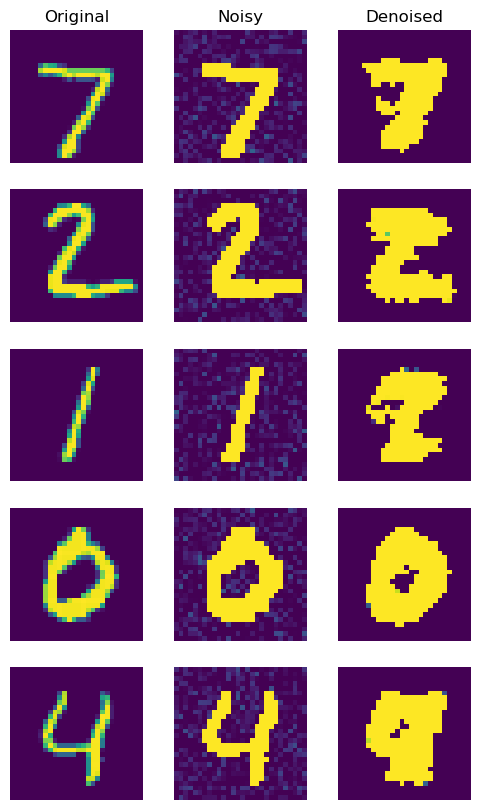

In [4]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

n_images = 5
new_images = X_test[:n_images]
new_images_noisy = new_images + np.random.randn(n_images, 28, 28) * 0.1
new_images_denoised = denoising_autoencoder.predict(new_images_noisy)

plt.figure(figsize = (6, n_images * 2))
for index in range(n_images):
    plt.subplot(n_images, 3, index * 3 + 1)
    plt.imshow(new_images[index])
    plt.axis("off")
    if index == 0:
        plt.title("Original")
    plt.subplot(n_images, 3, index * 3 + 2)
    plt.imshow(np.clip(new_images_noisy[index], 0., 1.))
    plt.axis("off")
    if index == 0:
        plt.title("Noisy")
    plt.subplot(n_images, 3, index * 3 + 3)
    plt.imshow(new_images_denoised[index])
    plt.axis("off")
    if index == 0:
        plt.title("Denoised")
plt.show()

In [5]:
class_NN = keras.models.Sequential([
    keras.layers.Input(shape = [28, 28]),
    keras.layers.Flatten(),
    keras.layers.Dense(300, activation = "relu"),
    keras.layers.Dense(100, activation = "relu"),
    keras.layers.Dense(10, activation = "softmax")
])

In [6]:
class_NN.compile(loss = "sparse_categorical_crossentropy",
                 optimizer = keras.optimizers.SGD(learning_rate = 1e-3), 
                 metrics = ["accuracy"])
class_NN.fit(X_train_500, y_train_500, epochs = 50,
             validation_data = (X_val, y_val))

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.1323 - loss: 2.2924 - val_accuracy: 0.1338 - val_loss: 2.2761
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.1617 - loss: 2.2560 - val_accuracy: 0.1474 - val_loss: 2.2615
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.1506 - loss: 2.2687 - val_accuracy: 0.1624 - val_loss: 2.2474
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.1832 - loss: 2.2184 - val_accuracy: 0.1774 - val_loss: 2.2336
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.1974 - loss: 2.2093 - val_accuracy: 0.1948 - val_loss: 2.2202
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.2001 - loss: 2.1952 - val_accuracy: 0.2148 - val_loss: 2.2071
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.2394 - loss: 2.1765 - val_accuracy: 0.2302 - val_loss: 2.1944
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.2656 - loss: 2.1411 - val_accuracy: 0.2520 - v

In [7]:
denoising_model = keras.models.load_model("best_denoising_autoencoder.keras")
combined_model = keras.models.Sequential([denoising_model, class_NN])
denoising_model_clone = keras.models.clone_model(denoising_model)
denoising_model_clone.set_weights(denoising_model.get_weights())

In [8]:
for layer in combined_model.layers[:-1]:
    layer.trainable = False

combined_model.compile(loss = "sparse_categorical_crossentropy",
                       optimizer = "nadam", metrics = ["accuracy"])
combined_model.fit(X_train_500, y_train_500, epochs = 15,
                   validation_data = (X_val, y_val))

Epoch 1/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.6968 - loss: 0.0000e+00 - val_accuracy: 0.8034 - val_loss: 0.0000e+00
Epoch 2/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.8688 - loss: 0.0000e+00 - val_accuracy: 0.8522 - val_loss: 0.0000e+00
Epoch 3/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8951 - loss: 0.0000e+00 - val_accuracy: 0.8512 - val_loss: 0.0000e+00
Epoch 4/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9209 - loss: 0.0000e+00 - val_accuracy: 0.8664 - val_loss: 0.0000e+00
Epoch 5/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9330 - loss: 0.0000e+00 - val_accuracy: 0.8738 - val_loss: 0.0000e+00
Epoch 6/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9663 - loss: 0.0000e+00 - val_accuracy: 0.8694 - val_loss: 0.0000e+00
Epoch 7/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9778 - loss: 0.0000e+00 - val_accuracy: 0.8750 - val_loss: 0.0000e+00
Epoch 8/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - ac

In [9]:
for layer in combined_model.layers[:-1]:
    layer_trainable = True

combined_model.compile(loss = "sparse_categorical_crossentropy",
                       optimizer = "nadam", metrics = ["accuracy"])
combined_model.fit(X_train_500, y_train_500, epochs = 35,
                   validation_data = (X_val, y_val))

Epoch 1/35
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9918 - loss: 0.0000e+00 - val_accuracy: 0.8792 - val_loss: 0.0000e+00
Epoch 2/35
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9851 - loss: 0.0000e+00 - val_accuracy: 0.8924 - val_loss: 0.0000e+00
Epoch 3/35
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.9962 - loss: 0.0000e+00 - val_accuracy: 0.8856 - val_loss: 0.0000e+00
Epoch 4/35
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.9982 - loss: 0.0000e+00 - val_accuracy: 0.8840 - val_loss: 0.0000e+00
Epoch 5/35
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9954 - loss: 0.0000e+00 - val_accuracy: 0.8756 - val_loss: 0.0000e+00
Epoch 6/35
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.9961 - loss: 0.0000e+00 - val_accuracy: 0.8650 - val_loss: 0.0000e+00
Epoch 7/35
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.9783 - loss: 0.0000e+00 - val_accuracy: 0.8878 - val_loss: 0.0000e+00
Epoch 8/35
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - ac

# 10.

In [ ]:
class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return keras.backend.random_normal(tf.shape(log_var)) * tf.exp(log_var/2) + mean

In [ ]:
codings_size = 10

inputs = keras.layers.Input(shape = [28, 28])
z = keras.layers.Flatten()(inputs)
z = keras.layers.Dense(150, activation = "selu")(z)
z = keras.layers.Dense(100, activation = "selu")(z)
codings_mean = keras.layers.Dense(codings_size)(z)
codings_log_var = keras.layers.Dense(codings_size)(z)
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = keras.Model(inputs = [inputs], 
                                  outputs = [codings_mean, codings_log_var, codings])

In [ ]:
decoder_inputs = keras.layers.Input(shape = [codings_size])
x = keras.layers.Dense(100, activation = "selu")(decoder_inputs)
x = keras.layers.Dense(150, activation = "selu")(x)
x = keras.layers.Dense(784, activation = "sigmoid")(x)
outputs = keras.layers.Reshape([28, 28])(x)
variational_decoder = keras.Model(inputs = [decoder_inputs],
                                  outputs = [outputs])

In [ ]:
_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_autoencoder = keras.Model(inputs = [inputs], outputs = [reconstructions])

In [ ]:
K = keras.backend

latent_loss = -0.5 * K.sum(
    1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean),
                           axis = -1)
variational_autoencoder.add_loss(K.mean(latent_loss) / 784.)
variational_autoencoder.compile(loss = "binary_crossentropy", optimizer = "rmsprop")
variational_autoencoder.fit(X_train, y_train, epochs = 20, batch_size = 128,
                            validation_data = (X_val, y_val))

# 11.

In [ ]:
codings_size = 100

generator = keras.models.Sequential([
    keras.layers.Input(shape = [codings_size]),
    keras.layers.Dense(6272, activation = "relu"),
    keras.layers.Reshape([7, 7, 128]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(64, kernel_size = 5, strides = 2, 
                                padding = "same", activation = "selu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(1, kernel_size = 5, strides = 2,
                                padding = "same", activation = "tanh")
])
discriminator = keras.models.Sequential([
    keras.layers.Input(shape = [28, 28, 1]),
    keras.layers.Conv2D(64, kernel_size = 5, strides = 2,
                        padding = "same", activation = keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.4),
    keras.layers.Conv2D(128, kernel_size = 5, strides = 2,
                        padding = "same", activation = keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.4),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation = "sigmoid")
])

dcgan = keras.models.Sequential([generator, discriminator])

In [ ]:
discriminator.compile(loss = "binary_crossentropy", optimizer = "rmsprop")
discriminator.trainable = False
dcgan.compile(loss = "binary_crossentropy", optimizer = "rmsprop")

In [ ]:
X_train_reshaped = X_train.reshape(-1, 28, 28, 1) * 2. - 1.

batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train_reshaped).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder = True).prefetch(1)

In [ ]:
def train_gan(gan, dataset, batch_size, codings_size, n_epochs = 25):
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        print("Epoch {}/{}".format(epoch + 1, n_epochs))              # not shown in the book
        for X_batch in dataset:
            # Phase 1 - Training the discriminator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis = 0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_and_real, y1)
            # Phase 2 - Training the generator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y2)
        plot_multiple_images(generated_images, 8)                     # not shown
        plt.show()

train_gan(dcgan, dataset, batch_size, codings_size)